# Example for running greenlight, displaying and analyzing simulation results

`GreenLight/notebooks/greenlight_example`<br>
Copyright (c) 2025 David Katzin, Wageningen Research Foundation<br>
SPDX-License-Identifier: BSD-3-Clause-Clear<br>
https://github.com/davkat1/GreenLight

**Note:** in order to get meaningful results, weather data (such as EnergyPlus data) should be included.
The same procedure that works for the main program also applies here,
see [docs/input_data.md#acquiring-input-data-for-the-greenlightmain-program](../docs/input_data.md#acquiring-input-data-for-the-greenlightmain-program)


A script version of this notebook is available at scripts/greenlight_example.py

## Running greenlight

In [1]:
"""
General imports and settings
"""
%load_ext autoreload
%autoreload 2

import datetime as dt
import os
import sys

import matplotlib  # If this fails, try to pip install matplotlib-inline
import pandas as pd
import warnings

# Set up directories
project_dir = os.path.abspath(os.path.join(os.path.abspath(""), ".."))
sys.path.append(project_dir)
import greenlight

In [3]:
"""
Simulation settings
"""
# Name of file containing the simulation output
output_file_name = "greenlight_example_output.csv"  

# Name of the unprocessed EnergyPlus CSV
original_energyPlus_csv = "NLD_Amsterdam.062400_IWECEPW.csv"  

# Chosen name for the processed EnergyPlus data
formatted_csv_name = "weather_ams_katzin_2021.csv"  

# First day of simulation season
start_date = dt.datetime(year=2020, month=9, day=27)  

# Length of simulated season, in days
simulation_length = 3  

In [4]:
"""
Set up simulation arguments
"""
# Base directory to be used by the model
base_path = os.path.join(project_dir, "greenlight", "models")

# Location (relative to base_path) of the main definition of the Katzin 2021 model, which will be used here
model = os.path.join("katzin_2021", "definition", "main_katzin_2021.json")

# Location of weather files, relative to base_path
original_file_directory = os.path.join("katzin_2021", "input_data", "energyPlus_original")
formatted_file_directory = os.path.join("katzin_2021", "input_data", "energyPlus_formatted")

# Modify directories to absolute path
original_file_directory = os.path.abspath(os.path.join(base_path, original_file_directory))
formatted_file_directory = os.path.abspath(os.path.join(base_path, formatted_file_directory))

# Outputs will be placed under katzin_2021/output
output_dir = os.path.join("katzin_2021", "output")

print(f"Base path: {base_path}\nModel location: {model}\nOutput location: {output_dir}")
# Numbers of days to simulate, in seconds
options = {
    "options": {"t_end": str(simulation_length * 24 * 3600)}
}

# Any other modification to the model
mods = [{"thetaLampMax": {"definition": "120"}}]  # Change the maximum lamp intensity to 120 W/m2

print(f"Number of days to simulate: {simulation_length}\nOther mods: {mods}")

Base path: C:\Users\katzi001\OneDrive - Wageningen University & Research\git\gitwur\GreenLight\greenlight\greenlight\models
Model location: katzin_2021\definition\main_katzin_2021.json
Output location: katzin_2021\output
Number of days to simulate: 3
Other mods: [{'thetaLampMax': {'definition': '120'}}]


In [5]:
"""
Add weather data
"""
# Weather data to use in case formatting the input weather data doesn't work
fallback_directory = os.path.abspath(os.path.join(base_path, os.path.join("katzin_2021", "input_data", "test_data")))
fallback_file = "Bleiswijk_from_20091020.csv"
try:
    formatted_file_name = greenlight.convert_energy_plus(
        os.path.join(original_file_directory, original_energyPlus_csv),
        os.path.join(formatted_file_directory, formatted_csv_name),
        t_out_start=start_date,
        t_out_end=start_date + dt.timedelta(days=simulation_length),
    )
except FileNotFoundError:
    warnings.warn("Couldn't find file:\n"
                  f"{os.path.abspath(os.path.join(original_file_directory, original_energyPlus_csv))}\n"
                  "Using built-in weather data instead")

    # Use built-in weather data
    formatted_file_directory = fallback_directory
    formatted_file_name = fallback_file
except Exception:
    warnings.warn("Failed to convert EnergyPlus file:\n"
                  f"{os.path.abspath(os.path.join(original_file_directory, original_energyPlus_csv))}\n"
                  "To formatted file:\n"
                  f"{os.path.abspath(os.path.join(formatted_file_directory, formatted_csv_name))}\n"
                  "Using built-in weather data instead"
                  )

    # Use built-in weather data
    formatted_file_directory = fallback_directory
    formatted_file_name = fallback_file

# Include the generated file in the simulation
mods.append(os.path.join(formatted_file_directory, formatted_file_name))

C:\Users\katzi001\AppData\Local\Temp\ipykernel_26508\1772521997.py:15: UserWarning: Couldn't find file:
C:\Users\katzi001\OneDrive - Wageningen University & Research\git\gitwur\GreenLight\greenlight\greenlight\models\katzin_2021\input_data\energyPlus_original\xxxNLD_Amsterdam.062400_IWECEPW.csv
Using built-in weather data instead
  warnings.warn("Couldn't find file:\n"


In [6]:
"""
Run the model
"""
input_arg = [model, options, mods]
output_arg = os.path.join(output_dir, output_file_name)
mdl = greenlight.GreenLight(base_path=base_path, input_prompt=input_arg, output_path=output_arg)
mdl.run()



Loading model from katzin_2021\definition\main_katzin_2021.json
Loading model from C:\Users\katzi001\OneDrive - Wageningen University & Research\git\gitwur\GreenLight\greenlight\greenlight\models\katzin_2021\input_data\test_data\Bleiswijk_from_20091020.csv
Simulation started at time (ISO format): 2025-09-24T11:21:32.744622
Running: 100.00%

Simulation complete at time (ISO format): 2025-09-24T11:21:49.468082
Simulated 3.0 days
Elapsed time: 16.723459720611572 seconds
Output saved to file katzin_2021\output\greenlight_example_output.csv
Model structure log saved to katzin_2021\output\greenlight_example_output_model_struct_log.json
Simulation log saved to katzin_2021\output\greenlight_example_output_simulation_log.txt


## Load, show, and interpret results

In [7]:
"""
Load simulation result
"""
output_df = pd.read_csv(os.path.join(base_path, output_dir, output_file_name), header=None, low_memory=False)
variable_names = output_df.iloc[0]
descriptions = output_df.iloc[1]
units = output_df.iloc[2]

# Reformat the DataFrame with variable names as columns
output_df = output_df.iloc[3:].reset_index(drop=True).apply(pd.to_numeric)
output_df.columns = variable_names

# Create dictionaries for descriptions and units
descriptions_dict = dict(zip(variable_names, descriptions))
units_dict = dict(zip(variable_names, units))

print(output_df.head(5))

0     Time       tCan       tAir       tFlr       tSo1       tSo2       tSo3  \
0      0.0  20.500000  16.500000  16.500000  16.500000  13.364000  10.228000   
1   3600.0  22.042819  23.816310  17.258151  16.126120  13.712704  10.380832   
2   7200.0  22.011593  23.829536  17.454075  16.347852  13.971431  10.540123   
3  10800.0  21.963559  23.808987  17.601102  16.533170  14.200419  10.701579   
4  14400.0  21.923336  23.791301  17.726248  16.691255  14.403047  10.862611   

0      tSo4      tSo5     tThScr  ...     parCan           rS          j  \
0  7.092000  3.956000  16.500000  ...   0.000000  2395.783162   0.000000   
1  7.129453  3.997912  18.611130  ...  44.419012   688.595986  12.589035   
2  7.169656  4.039677  18.700656  ...  47.403730   689.037385  13.455062   
3  7.212602  4.081312  18.531681  ...  50.359070   688.894395  14.311070   
4  7.258214  4.122834  18.365388  ...  53.284683   688.728038  15.162552   

0     vecCanAir         p         r      mvCanAir  mcAirBuf   

In [8]:
"""
Choose variables to show
"""
# Choose variables out of output_df.columns
# For a description of a variable var, see descriptions_dict[var]. For the unit, see units_dict[var]
chosen_vars = ["tOut", "tAir", "tCan", "qLampIn", "lai", "cFruit", "mcFruitHar", "hBoilPipe", "hBoilGroPipe"]

for var in chosen_vars:
    print(f"{var}: {descriptions_dict[var]} ({units_dict[var]})")

tOut: Outdoor temperature (°C)
tAir: Temperature of the air in the main compartment of the greenhouse (below the screen) (°C)
tCan: Canopy temperature (°C)
qLampIn: Lamp electrical input (W m**-2)
lai: Leaf area index (m**2 {leaf} m**-2 {floor})
cFruit: Carbohydrates in the fruit (mg{CH2O} m**-2)
mcFruitHar: Fruit harvest rate (mg{CH2O} m**-2 s**-1)
hBoilPipe: Heat flux from the boiler to the heating pipe (W m**-2)
hBoilGroPipe: Heat from boiler to grow pipes (W m**-2)


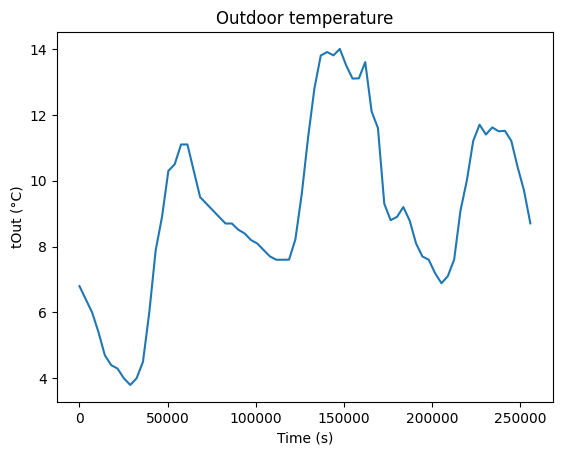

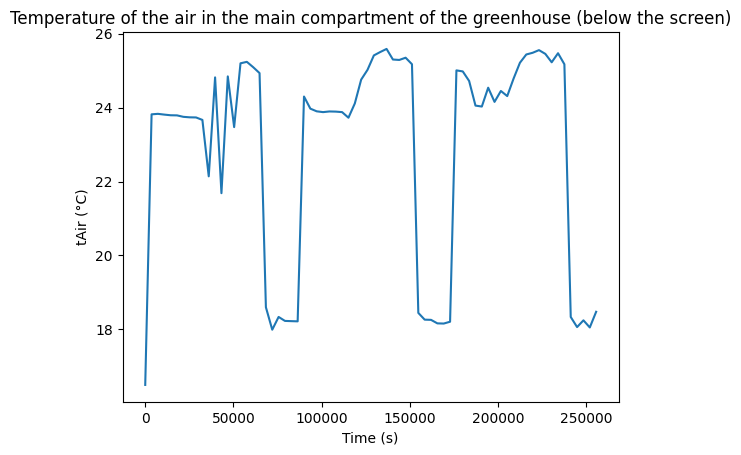

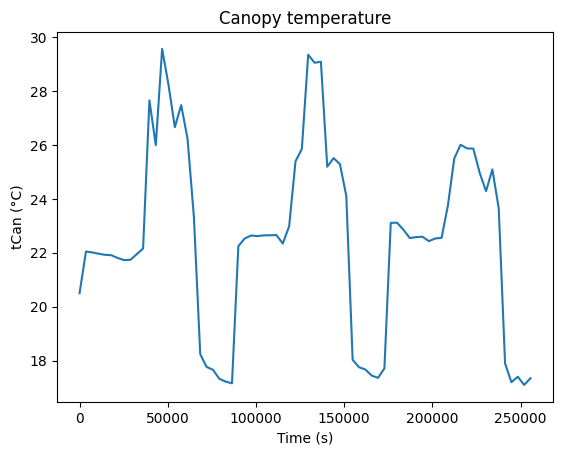

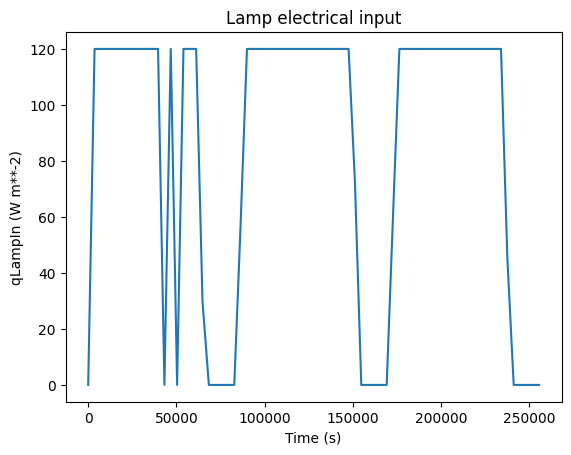

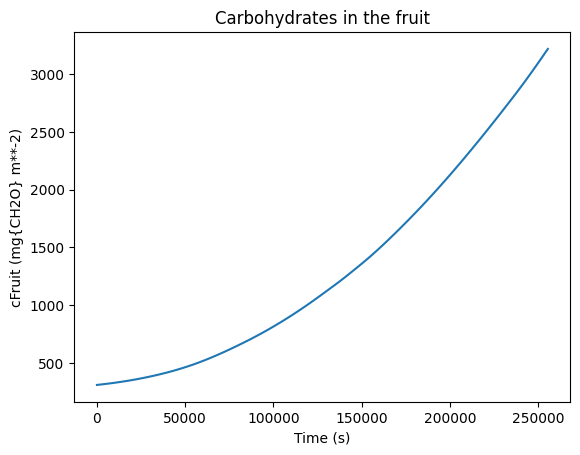

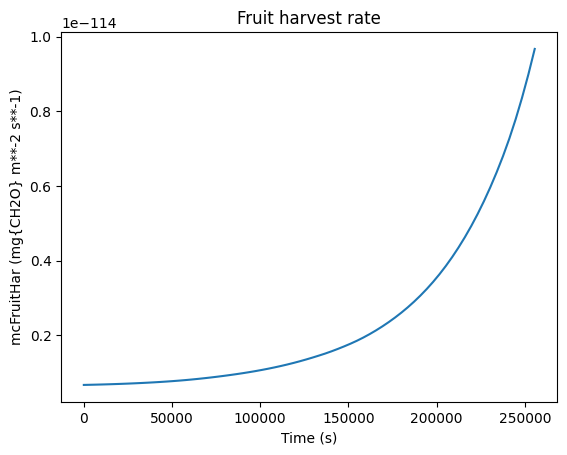

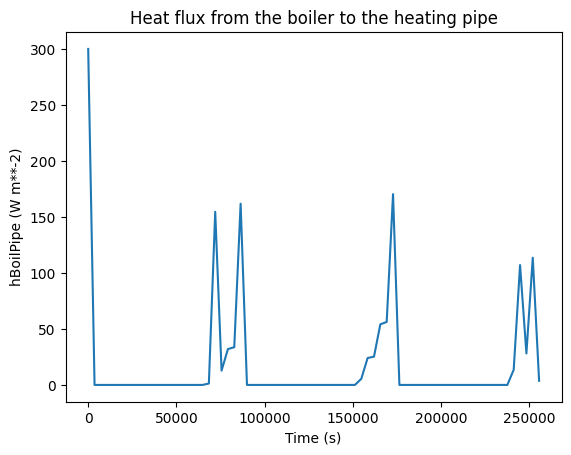

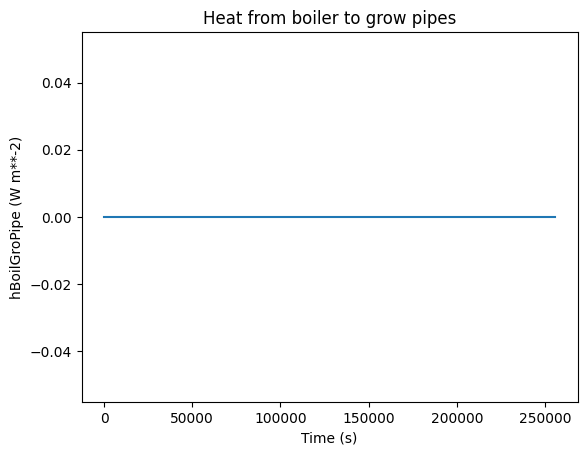

In [9]:
"""
Show some graphs
"""
# Choose variables out of output_df.columns
# For a description of a variable var, see descriptions_dict[var]. For the unit, see units_dict[var]
chosen_vars = ["tOut", "tAir", "tCan", "qLampIn", "cFruit", "mcFruitHar", "hBoilPipe", "hBoilGroPipe"]

for var in chosen_vars:
    output_df.plot(x="Time", y=var, xlabel="Time (s)", ylabel=f"{var} ({units_dict[var]})", title=descriptions_dict[var], legend=None);

In [12]:
"""
Calculate yield, energy use, CO2 use, water use
"""
# The time steps (in s) in the output data
time_step = output_df.loc[1,"Time"] - output_df.loc[0,"Time"]
print(f'Time step size: {time_step} seconds')
print(f'Simulation length: {(output_df["Time"].iloc[-1] - output_df["Time"].iloc[0])/86400} days')

# Assumed fruit dry matter content
dmc = 0.06

# Total yield, kg fresh weight per m**2
tot_yield = time_step*sum(output_df["mcFruitHar"])*1e-6/dmc
print(f"Yield: {tot_yield} kg/m2")

# Energy for heating, MJ m**2
energy_heat = time_step*(sum(output_df["hBoilPipe"]) + sum(output_df["hBoilGroPipe"]))*1e-6
print(f"Energy used for heating: {energy_heat} MJ/m2")

# Energy for lighting, MJ m**2
energy_light = time_step*(sum(output_df["qLampIn"]) + sum(output_df["qIntLampIn"]))*1e-6
print(f"Energy used for lighting: {energy_light} MJ/m2")


# Total CO2 use (for CO2 injection), kg m**2
tot_co2 = time_step*sum(output_df["mcExtAir"])*1e-6
print(f"CO2 use: {tot_co2} kg/m2")

# Assumed ratio between total transpiration and total irrigation
# If drain is recirculated, transpiration is about 90% of irrigation, irrigation is about 1.1 times transpiration
trans_to_irrig = 1.1
# Total water use (for irrigation), kg m**2
tot_h20 = time_step*trans_to_irrig*sum(output_df["mvCanAir"])
print(f"Water use for irrigation: {tot_h20} liters/m2")

Time step size: 3600.0 seconds
Simulation length: 2.9583333333333335 days
Yield: 7.397950133611374e-115 kg/m2
Energy used for heating: 9.038991703646733 MJ/m2
Energy used for lighting: 7.829793238124036 MJ/m2
CO2 use: 0.42660744352762314 kg/m2
Water use for irrigation: 1.9664389160479403 liters/m2
